In [1]:
from VisionClass import VisionClass
from GlobalMapClass import GlobalMapClass
import ShorthestPath
from KalmanFilterClass import KalmanFilterClass
import numpy as np
import matplotlib.pyplot as plt 

# Déclaration de Variable

In [2]:
#flag
kidnap=False
bloqued=False
reachedGoal=False

#variables declaration
globalMap=GlobalMapClass()
kalmanFilter=KalmanFilterClass()
input=np.matrix([[0],[0],[0]])
timeStep=0
measurement=None
angleToGoal=None

In [3]:
import cv2

In [4]:
vision=VisionClass((139,90))
vision.initialize()

87 59 149
66 72 31
87 59 149 66 72 31


True
32 32 517 394


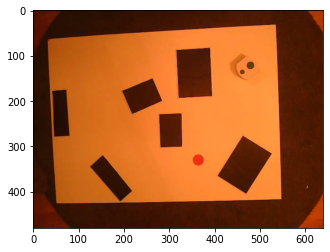

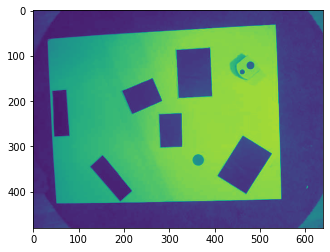

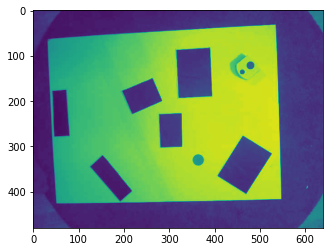

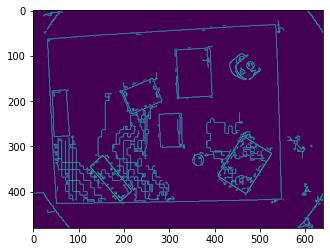

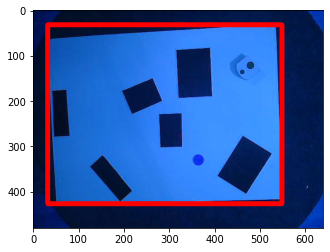

In [5]:
vision.update()
succes = vision.Size()
print(succes)

plt.imshow(cv2.cvtColor(vision.image,cv2.COLOR_BGR2RGB))
plt.figure()
plt.imshow(vision.map)
plt.figure()
plt.imshow(vision.mask)
plt.figure()
plt.imshow(vision.erode)
plt.figure()
plt.imshow(vision.imageDraw)

print(vision.cornerX,vision.cornerY,vision.ratioX,vision.ratioY)

In [15]:
vision.finish()

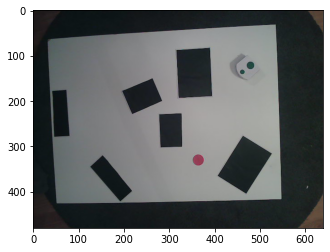

In [6]:
vision.update()
plt.imshow(cv2.cvtColor(vision.image,cv2.COLOR_BGR2RGB))

[121, 14, 2.3758]


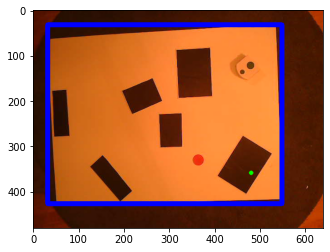

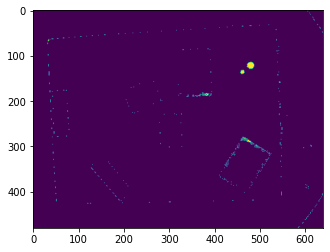

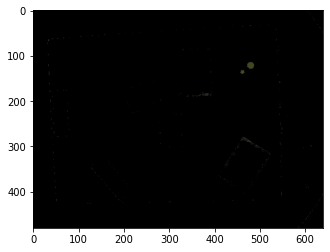

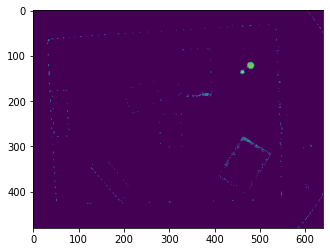

In [8]:
print(vision.robotDetection())
plt.figure()
plt.imshow(cv2.cvtColor(vision.imageDraw,cv2.COLOR_BGR2RGB))
plt.figure()
plt.imshow(vision.mask)
plt.figure()
plt.imshow(vision.erode)
plt.figure()
plt.imshow(vision.binary)

[89, 21]


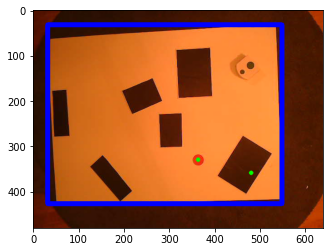

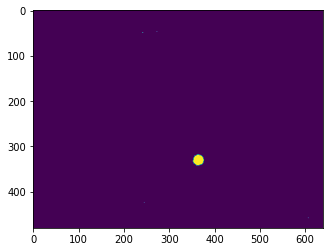

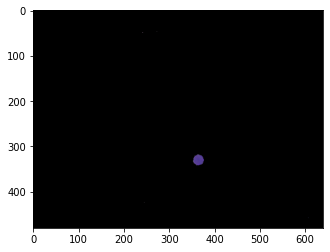

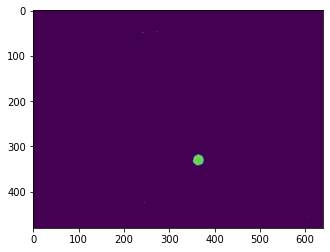

In [9]:
print(vision.goalDetection())
plt.figure()
plt.imshow(cv2.cvtColor(vision.imageDraw,cv2.COLOR_BGR2RGB))
plt.figure()
plt.imshow(vision.mask)
plt.figure()
plt.imshow(vision.erode)
plt.figure()
plt.imshow(vision.binary)

[120, 69, -2.3561945]
[89, 21]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
90


TypeError: object of type 'bool' has no len()

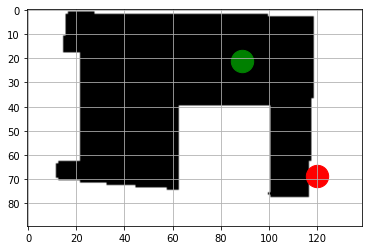

In [9]:
plt.imshow(vision.obstaclesDetection(), cmap="gray")
plt.scatter(vision.robotDetection()[0],vision.robotDetection()[1], marker="o", color="red", s=500)
plt.scatter(vision.goalDetection()[0],vision.goalDetection()[1], marker="o", color="green", s=500)
plt.grid()
globalMap.setObstacles(vision.obstaclesDetection())
globalMap.setRobot(vision.robotDetection())
globalMap.setGoal(vision.goalDetection())
globalMap.setMapSize(90,139)
print(globalMap.getRobot())
print(globalMap.getGoal())
print(globalMap.getObstacles())
print(globalMap.getMapSize()[0])
globalMap.setPath(ShorthestPath.astar(globalMap.getObstacles(),globalMap.getMapSize()[0],
                                      globalMap.getMapSize()[1], globalMap.getRobot(),
                                      globalMap.getGoal()))
route = ShorthestPath.astar(globalMap.getObstacles(),globalMap.getMapSize()[0],
                                      globalMap.getMapSize()[1], globalMap.getRobot(),
                                      globalMap.getGoal())

x_coords = []
y_coords = []
for i in (range(0,len(route))):
    x = route[i][0]
    y = route[i][1]
    x_coords.append(x)
    y_coords.append(y)

# plot map and path
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(globalMap.getObstacles(), cmap=plt.cm.Dark2)
ax.scatter(globalMap.getRobot()[0],globalMap.getRobot()[1], marker = "*", color = "yellow", s = 200)
ax.scatter(globalMap.getGoal()[0],globalMap.getGoal()[1], marker = "*", color = "red", s = 200)
ax.plot(y_coords,x_coords, color = "black")
plt.show()

In [11]:
map_raw = cv2.imread('Final_map.jpg')
grid_size = 40
globalMap.setObstacles(vision.obstaclesDetection(map_raw, grid_size))
globalMap.setPos(vision.robotDetection(map_raw))
globalMap.setGoal(vision.goalDetection(map_raw))
goal_pos=globalMap.getPos()
thymio_pos=globalMap.getGoal()
map_occupancy = vision.preprocessing(map_raw)
height = grid_size # Size of the grid
width = round(map_occupancy.shape[1]/map_occupancy.shape[0]*height)
ratio = round(map_occupancy.shape[0]/height)
globalMap.setGoal([goal_pos[0]/ratio, grid_size-goal_pos[1]/ratio])
globalMap.setPos([thymio_pos[0][0]/ratio, grid_size-thymio_pos[1]/ratio, -globalMap.robot[2]])
print([thymio_pos[0][0]/ratio, grid_size-thymio_pos[1]/ratio, -globalMap.robot[2]])
print(globalMap.getPos())
globalMap.setPath(ShorthestPath.astar(globalMap.obstacles,height,
                                      width, globalMap.getPos(),
                                      globalMap.getGoal()))

[matrix([[51.98148]], dtype=float32), matrix([[11.24074]], dtype=float32), matrix([[0.37239844]], dtype=float32)]


TypeError: unhashable type: 'list'

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure



# plot map and path
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "*", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "*", color = "red", s = 200)
ax.plot(y_coords,x_coords, color = "black")
plt.show()

# Initialisation

In [ ]:
#Vision initialisation
vision.initialize()

#Kalman filter initialisation
kalmanFilter.setState(vision.robotDetection())

#map initialisation
gloablMap.mapSize(vision.height, vision.width)
globalMap.setPos(kalmanFilter.x)
globalMap.setGoal(vision.goalDetection())
globalMap.setObstacles(vision.obstaclesDetection())

#Shorthest path computation
gloablMap.setPath(ShorthestPath.aStar(globalMap.getObstacles(),gloablMap.getMapSize()[0],
                                      gloablMap.getMapSize()[1], gloablMap.getPos(),
                                      globalMap.getGoal()))
